In [29]:
!pip install optuna

In [30]:
pip install category_encoders

---
## Setup

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import auc

In [32]:
train = pd.read_csv('training_dataset.csv')
test = pd.read_csv('validation_set.csv')


---
## Data Exploration

In [33]:
train.head()

,customer_number,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,531036,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,999241,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,995002,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,932750,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,684699,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_number               22916 non-null  int64  
 1   usia                          22916 non-null  int64  
 2   pekerjaan                     22916 non-null  object 
 3   status_perkawinan             22916 non-null  object 
 4   pendidikan                    22916 non-null  object 
 5   gagal_bayar_sebelumnya        22916 non-null  object 
 6   pinjaman_rumah                22916 non-null  object 
 7   pinjaman_pribadi              22916 non-null  object 
 8   jenis_kontak                  22916 non-null  object 
 9   bulan_kontak_terakhir         22916 non-null  object 
 10  hari_kontak_terakhir          22916 non-null  object 
 11  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 12  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 13  j

In [35]:
def check_anomali(df):
    print('Shape Data')
    print(df.shape)
    print('-'*10)
    print()
    print('Missing Value : ')
    print(df.isna().mean()*100)
    print('-'*10)
    print()
    print('Data Duplicated : ')
    print(df.duplicated().sum())

In [36]:
check_anomali(train)

Shape Data
(22916, 22)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
berlangganan_deposito           0.0
dtype: float64
----------

Data Duplicated : 
0


In [37]:
check_anomali(test)

Shape Data
(5729, 21)
----------

Missing Value : 
customer_number                 0.0
usia                            0.0
pekerjaan                       0.0
status_perkawinan               0.0
pendidikan                      0.0
gagal_bayar_sebelumnya          0.0
pinjaman_rumah                  0.0
pinjaman_pribadi                0.0
jenis_kontak                    0.0
bulan_kontak_terakhir           0.0
hari_kontak_terakhir            0.0
jumlah_kontak_kampanye_ini      0.0
hari_sejak_kontak_sebelumnya    0.0
jumlah_kontak_sebelumnya        0.0
hasil_kampanye_sebelumnya       0.0
tingkat_variasi_pekerjaan       0.0
indeks_harga_konsumen           0.0
indeks_kepercayaan_konsumen     0.0
suku_bunga_euribor_3bln         0.0
jumlah_pekerja                  0.0
pulau                           0.0
dtype: float64
----------

Data Duplicated : 
0


In [38]:
train.describe()

,customer_number,usia,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,berlangganan_deposito
count,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000,22916.000000
mean,550930.993193,40.016233,2.561878,962.210377,0.170143,0.077915,93.576541,-40.485717,3.617890,5166.773124,0.114069
std,259909.889175,10.438059,2.794178,187.566774,0.490611,1.576176,0.580586,4.641091,1.737591,72.479698,0.317902
min,100108.000000,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,325755.000000,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,553139.000000,38.000000,2.000000,999.000000,0.000000,1.100000,93.876000,-41.800000,4.857000,5191.000000,0.000000
75%,777157.500000,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,999997.000000,98.000000,42.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


---
## EDA

In [39]:
for col in test.columns:
    train = train[train[col] != 'unknown']
    test = test[test[col] != 'unknown']



In [40]:
cat_cols_train = train.select_dtypes(include=['object', 'category'])
num_cols_train = train.select_dtypes(include='number')

cat_cols_test = test.select_dtypes(include=['object', 'category'])
num_cols_test = test.select_dtypes(include='number')

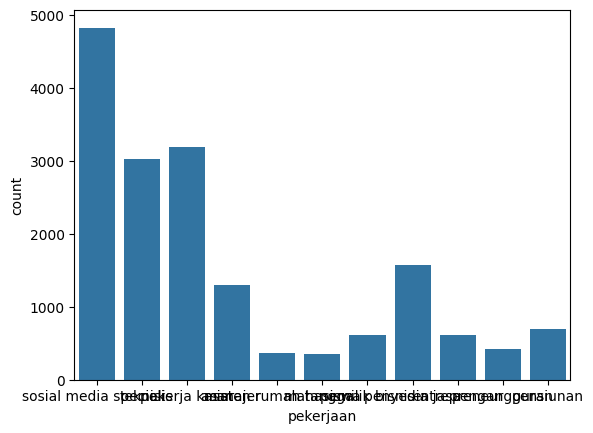

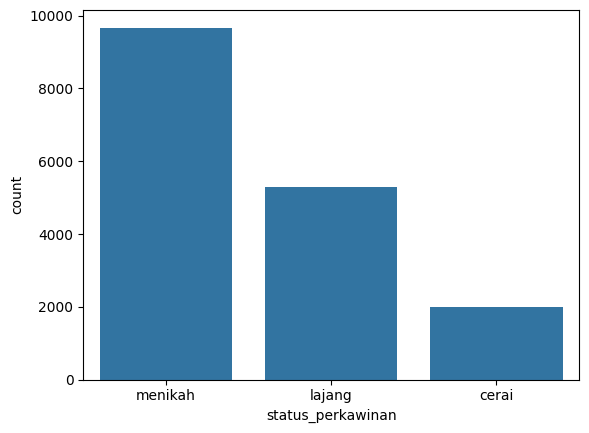

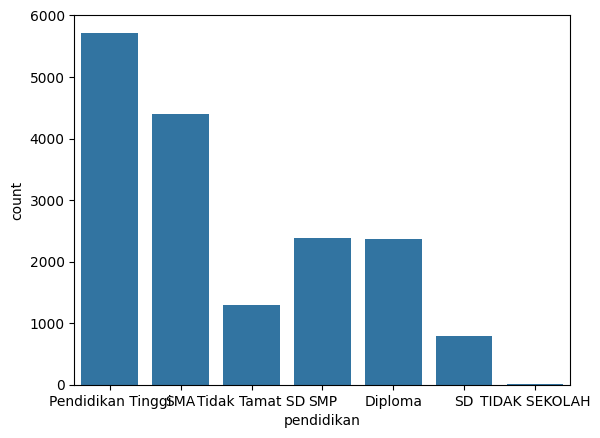

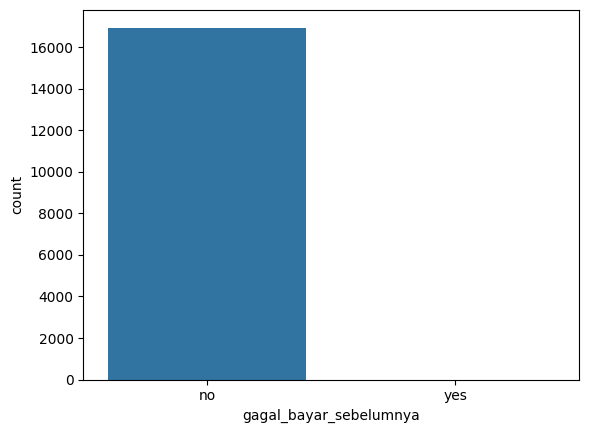

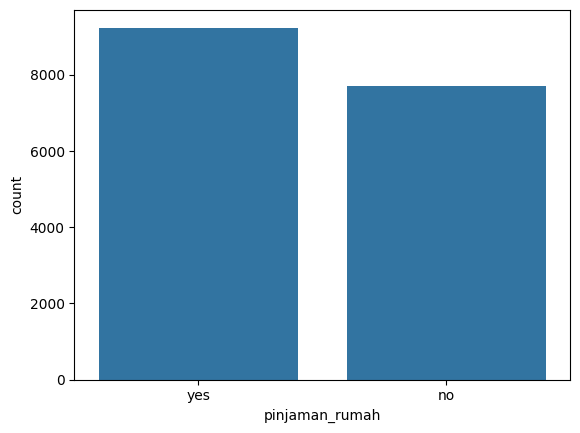

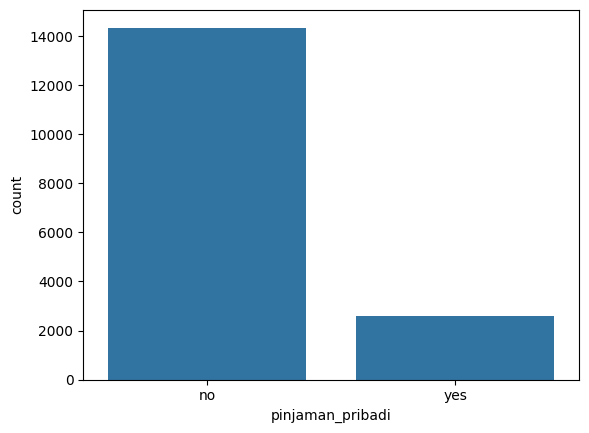

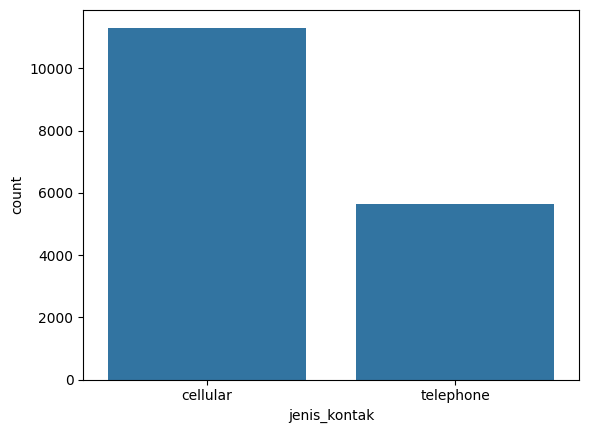

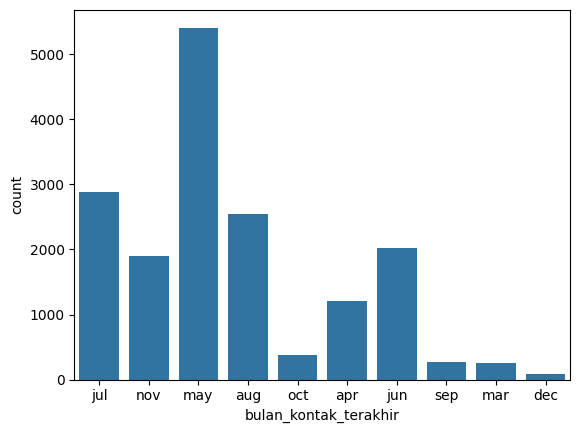

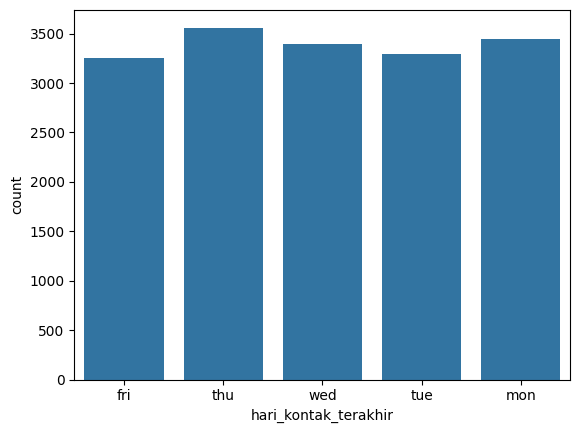

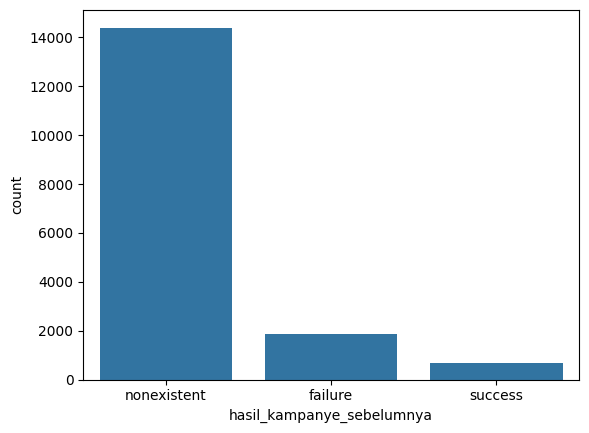

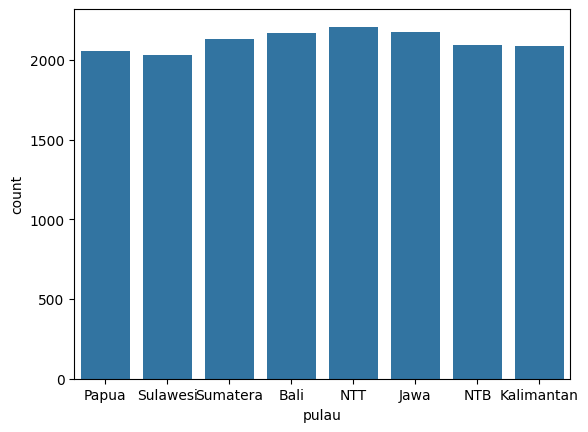

In [41]:
#visualization of categorical data
for col in cat_cols_train:
    sns.countplot(x=col, data=train)
    plt.show()

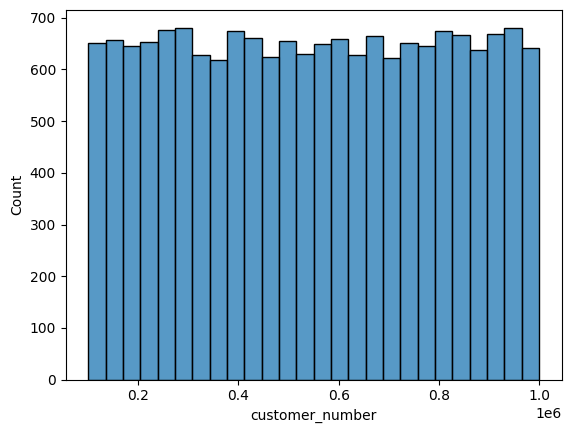

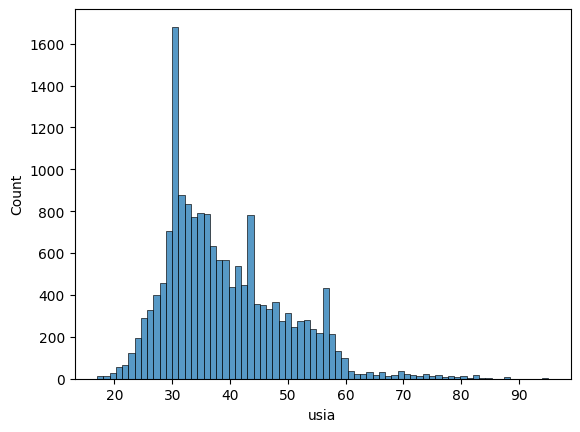

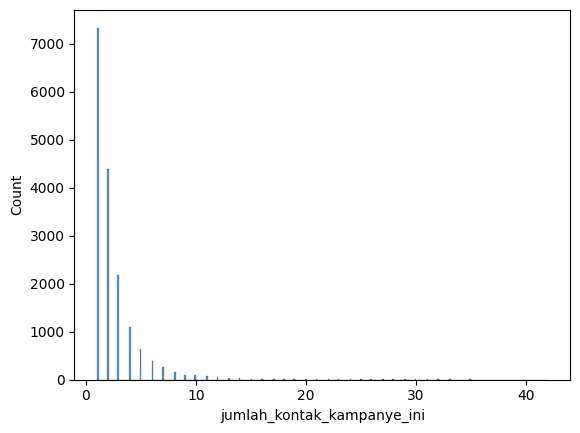

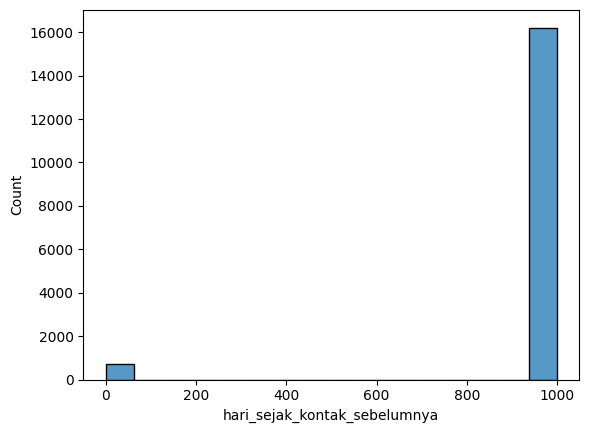

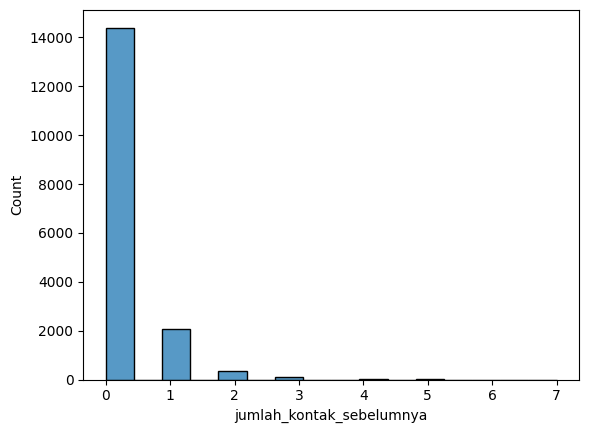

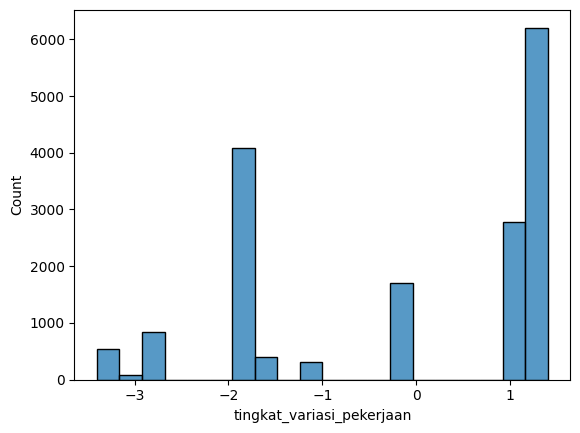

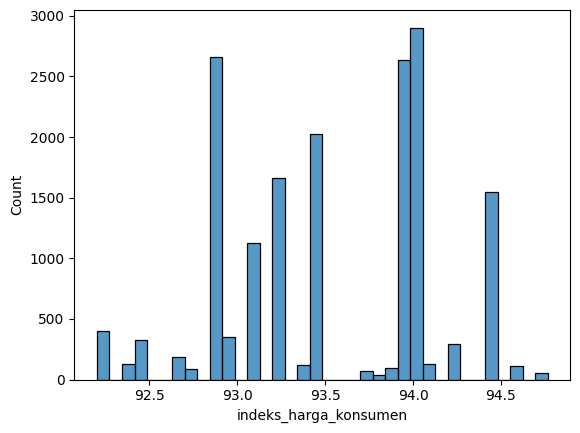

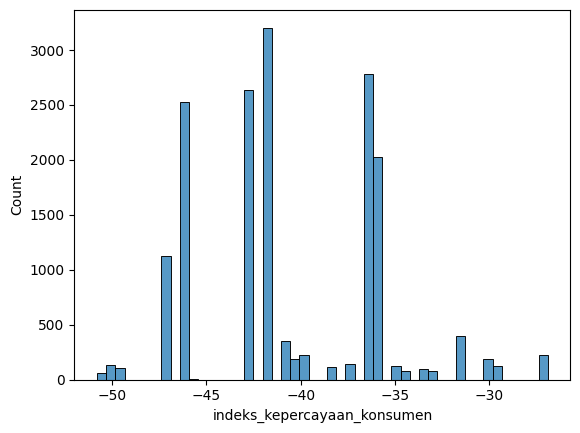

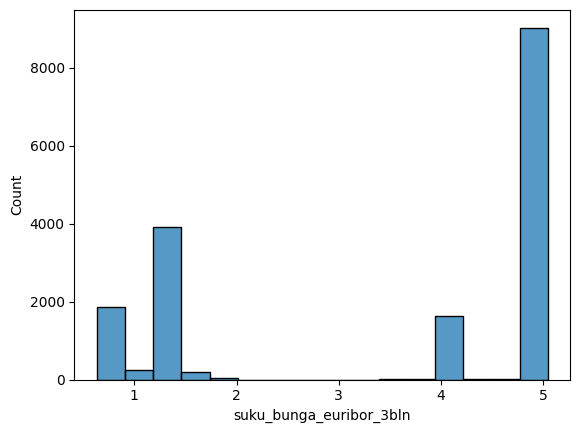

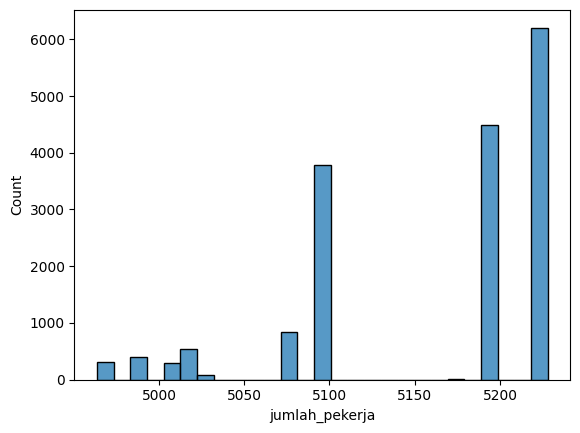

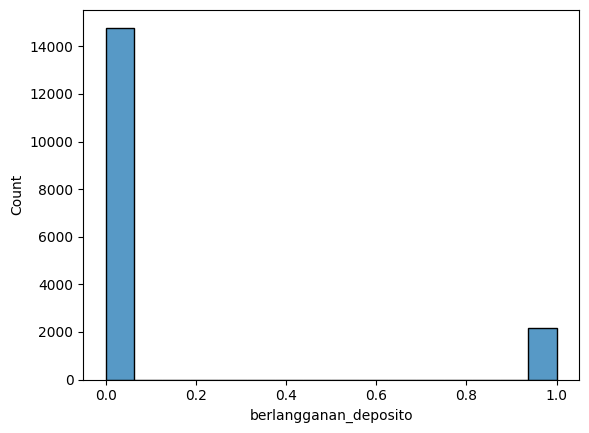

In [42]:
#visualization of numerical data
for col in num_cols_train:
    sns.histplot(x=col, data=train)
    plt.show()

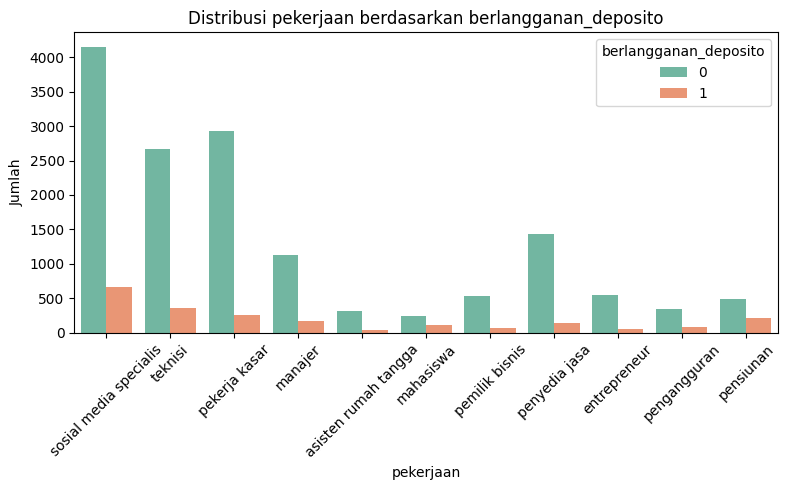

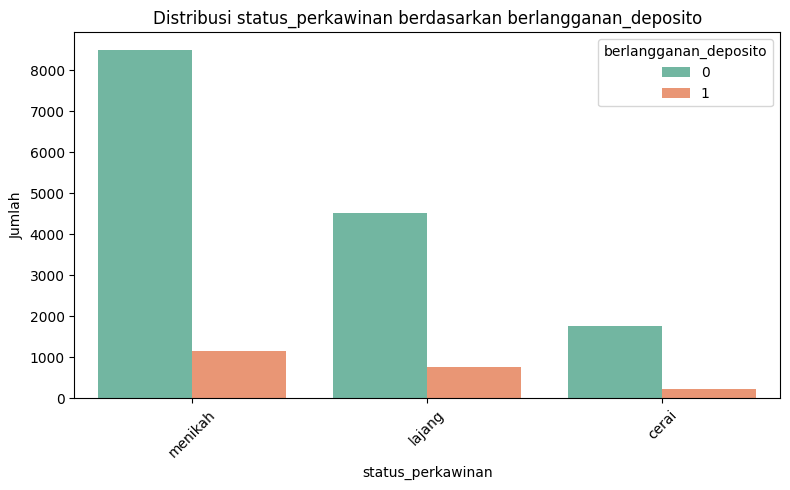

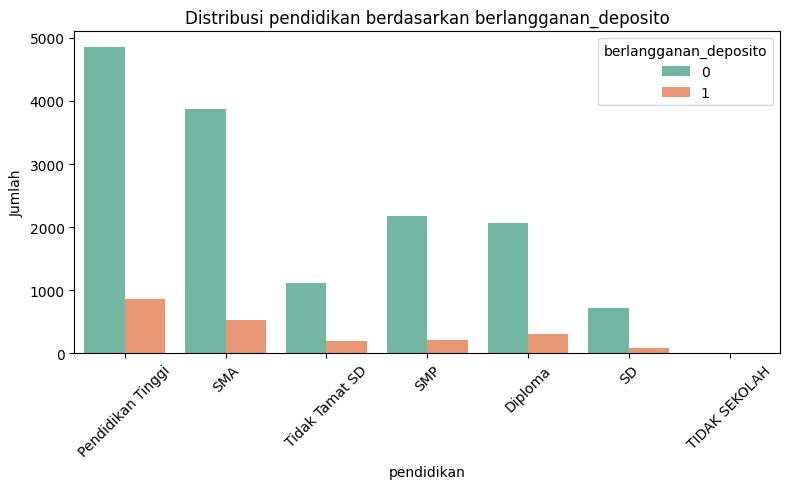

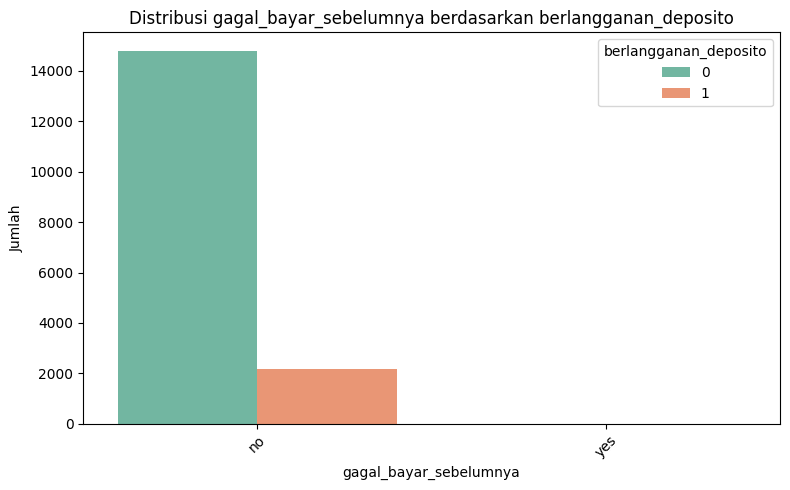

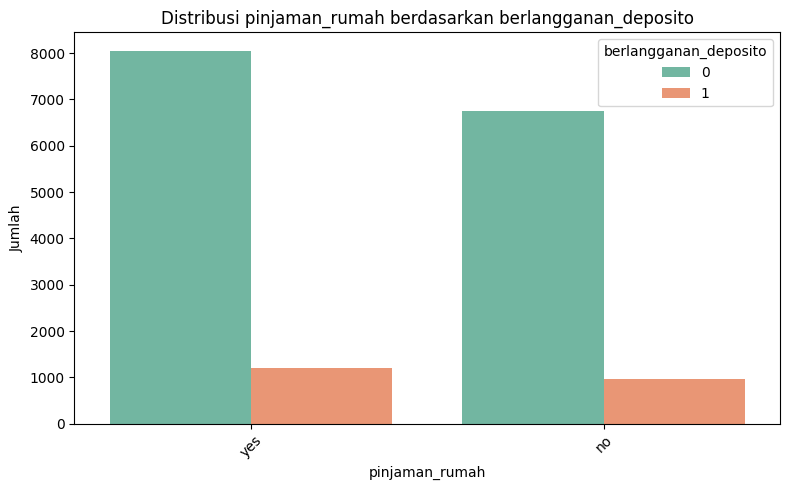

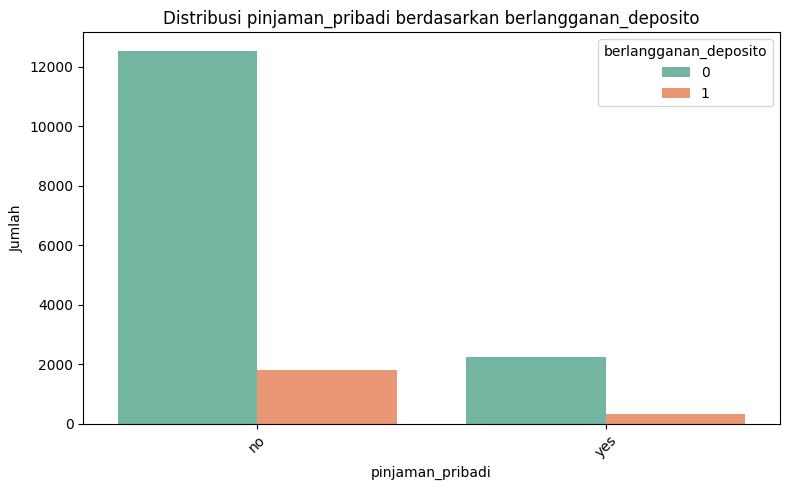

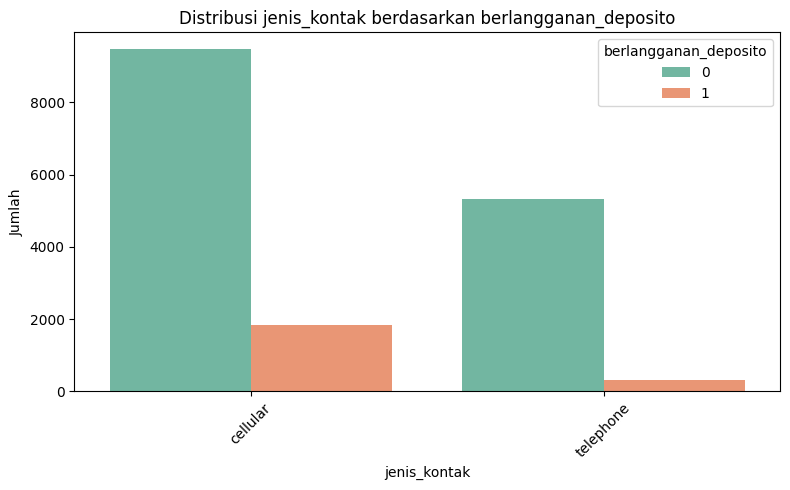

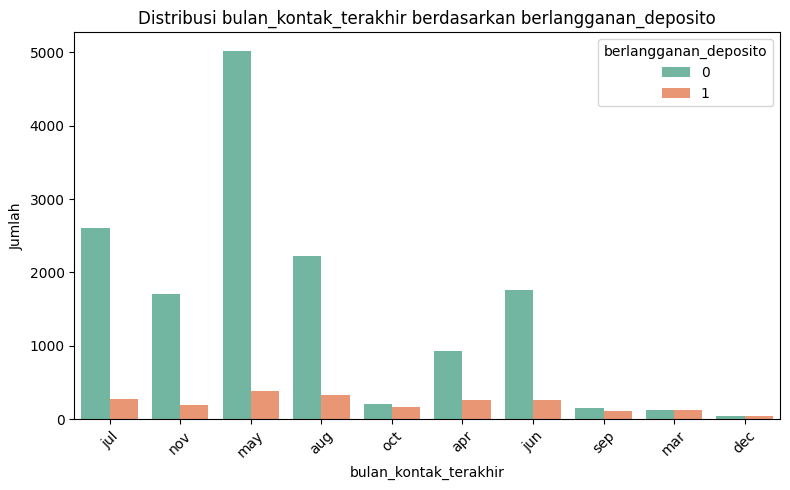

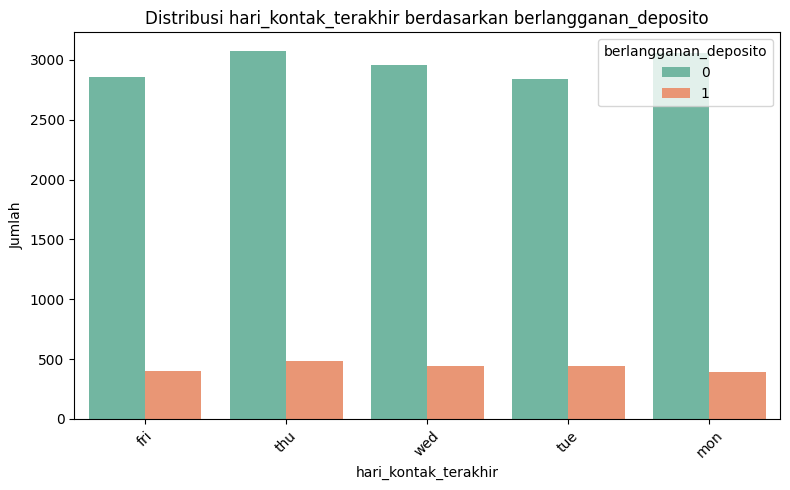

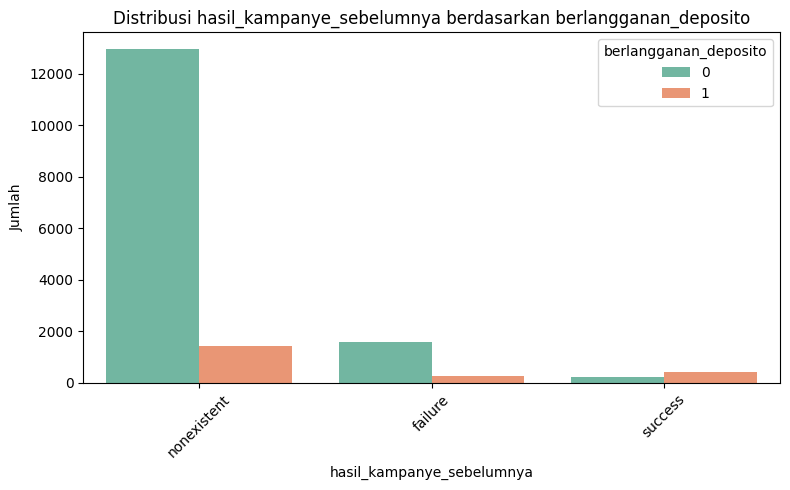

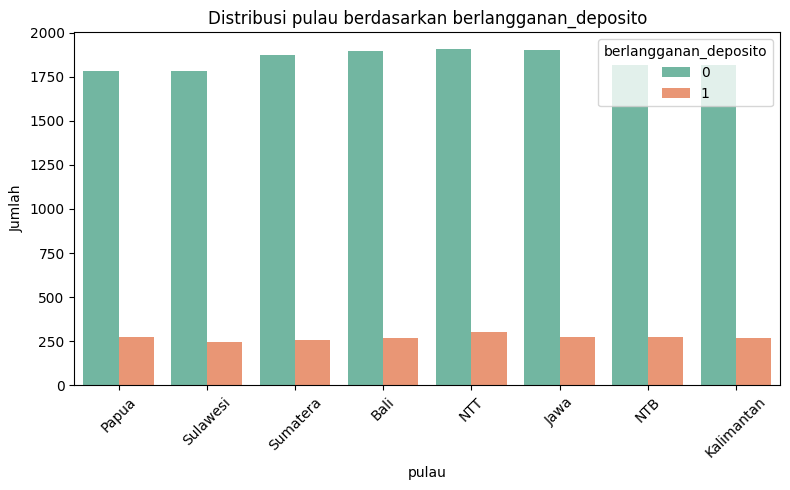

In [43]:
def plot_categorical_distribution(df, categorical_cols, target_col):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, hue=target_col, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Contoh pemanggilan (pastikan target_col adalah string, bukan Series)
plot_categorical_distribution(train, cat_cols_train, 'berlangganan_deposito')


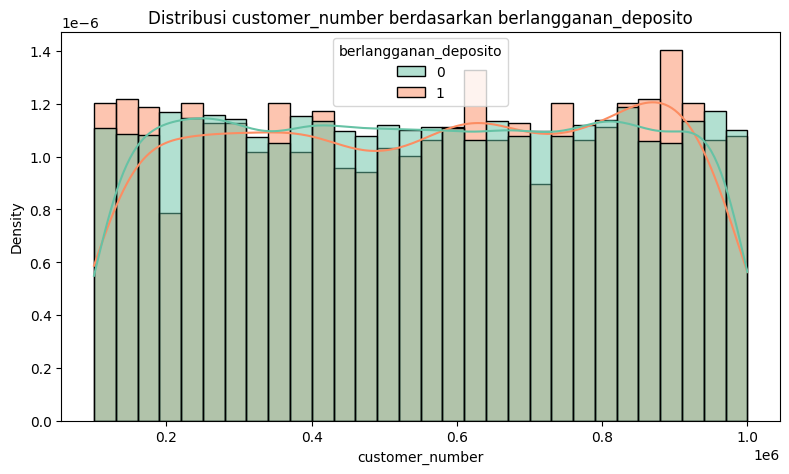

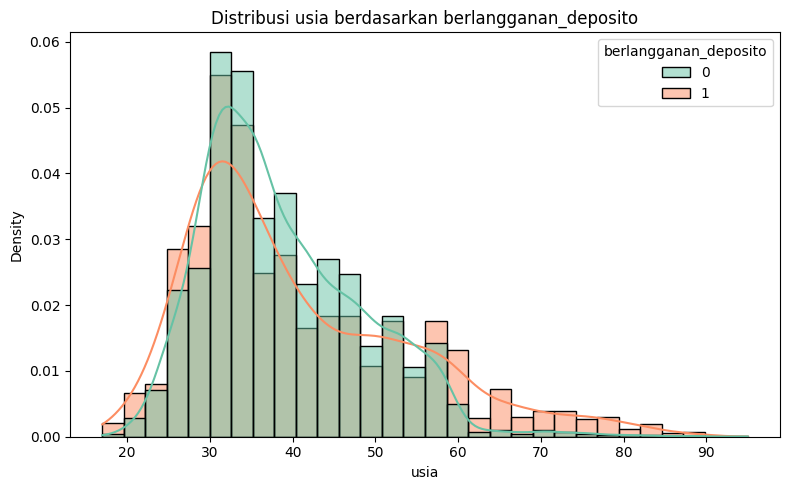

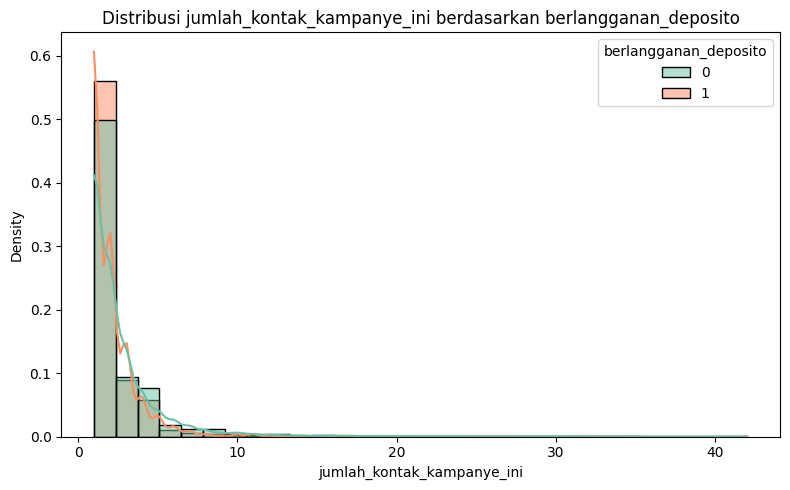

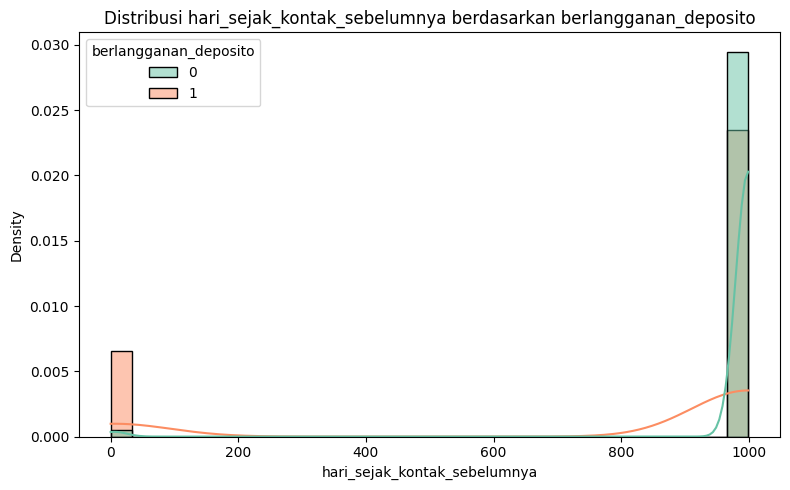

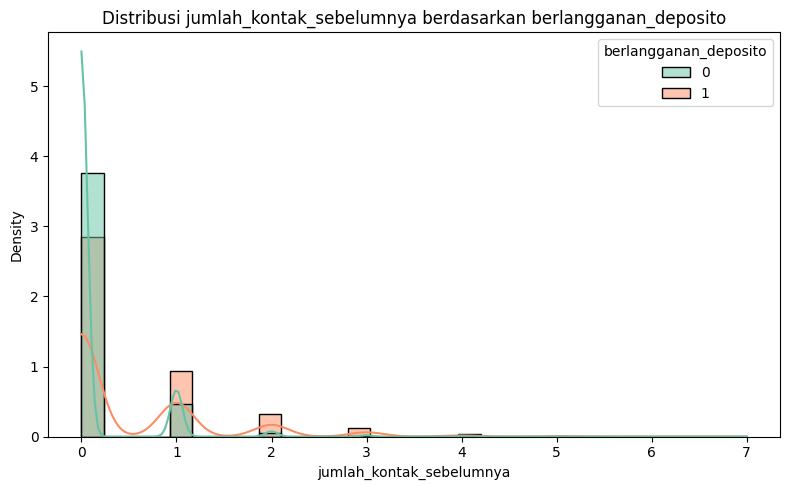

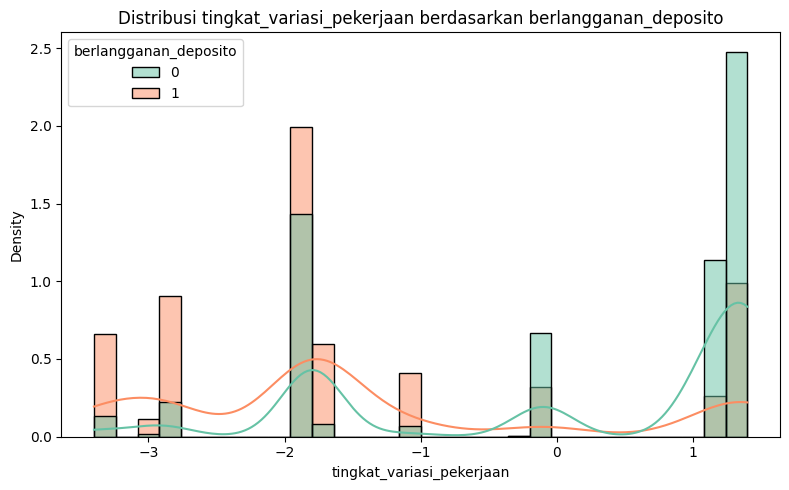

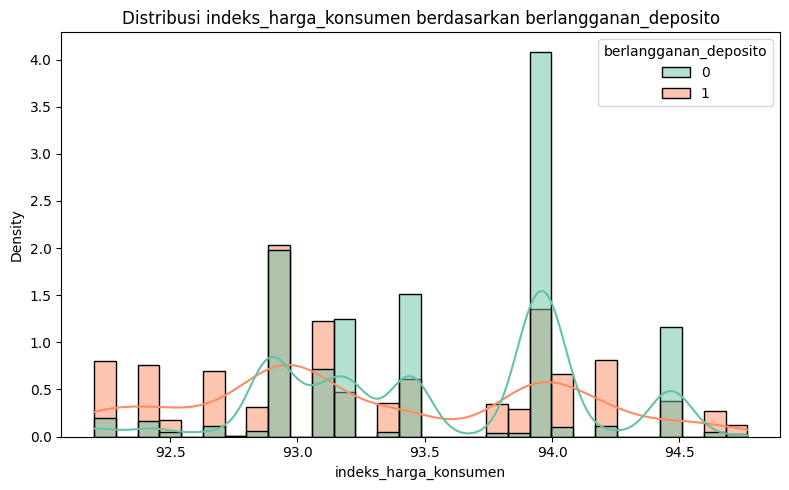

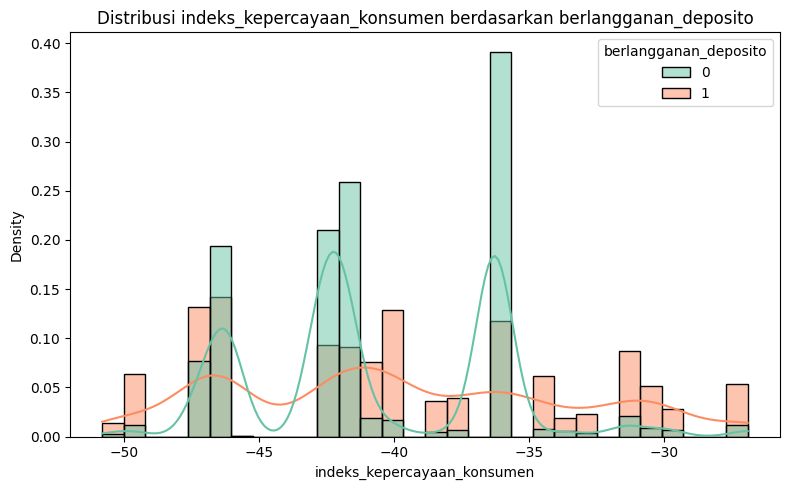

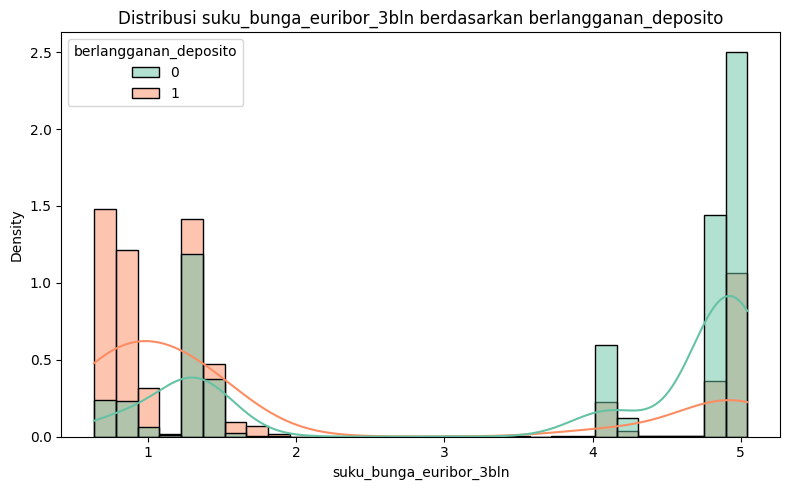

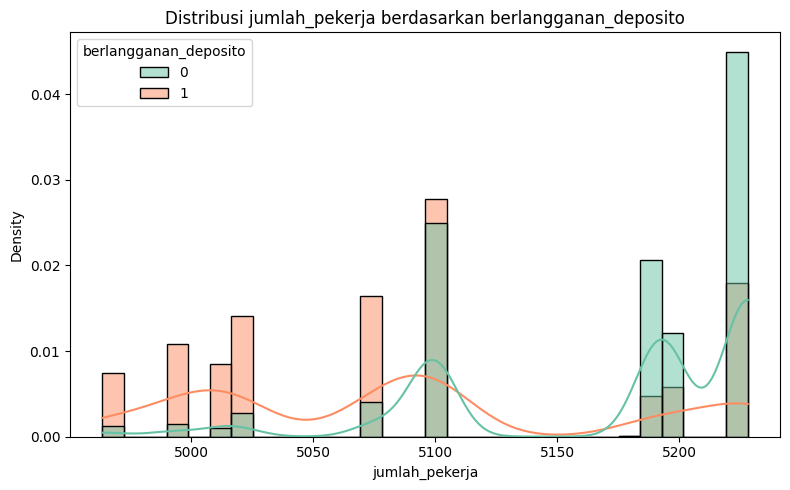

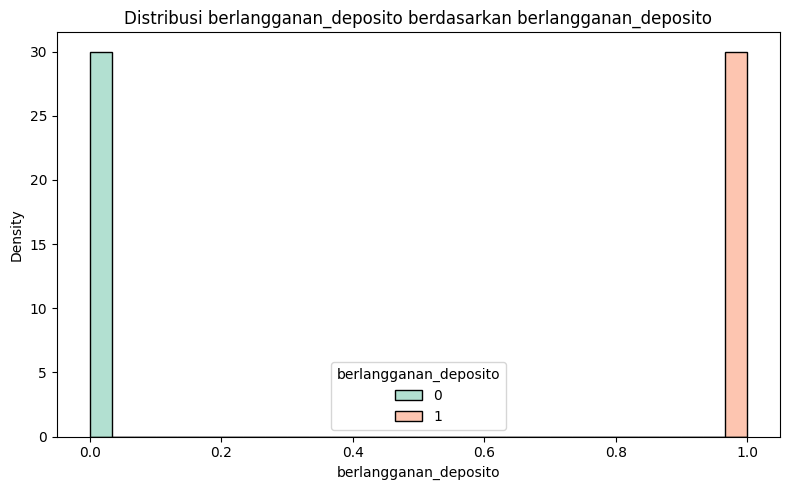

In [44]:
def plot_histplots(df, num_cols, target_col, bins=30):
    for col in num_cols:
        plt.figure(figsize=(8, 5))
        sns.histplot(data=df, x=col, hue=target_col, bins=bins, kde=True, stat="density", common_norm=False, palette='Set2')
        plt.title(f'Distribusi {col} berdasarkan {target_col}')
        plt.tight_layout()
        plt.show()


plot_histplots(train, num_cols_train, 'berlangganan_deposito')

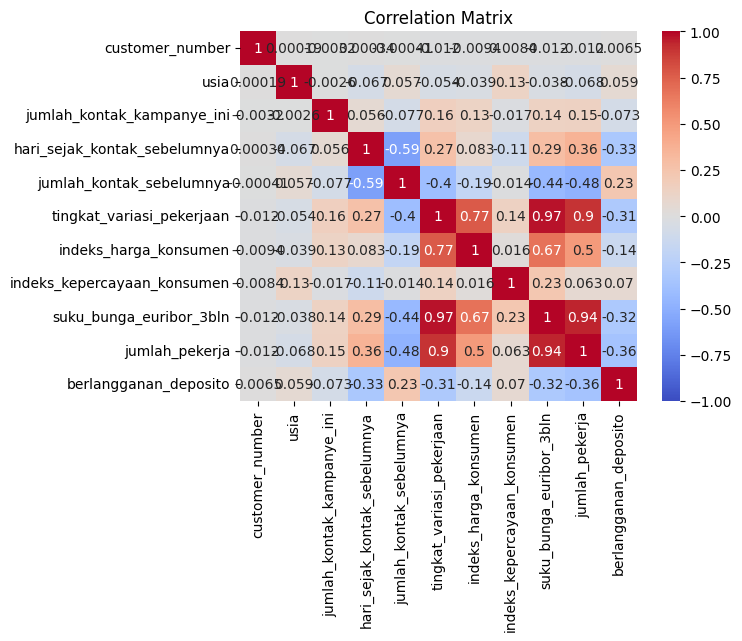

In [45]:
#heatmap correlation numerical
corr_matrix = train[num_cols_train.columns.tolist()].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(train[num_cols_train.columns.tolist()])

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data["Fitur"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                           Fitur            VIF
0                          const  546388.379286
1                customer_number       1.000348
2                           usia       1.026664
3     jumlah_kontak_kampanye_ini       1.036178
4   hari_sejak_kontak_sebelumnya       1.686717
5       jumlah_kontak_sebelumnya       1.773156
6      tingkat_variasi_pekerjaan      32.844199
7          indeks_harga_konsumen       6.959633
8    indeks_kepercayaan_konsumen       2.573907
9        suku_bunga_euribor_3bln      63.802464
10                jumlah_pekerja      33.430796
11         berlangganan_deposito       1.226743


In [47]:
# Fitur quasi-constant: mayoritas nilainya sama (default threshold = 0.99)
threshold = 0.96
quasi_constant_features = []

for col in train.columns:
    top_freq = train[col].value_counts(normalize=True).values[0]
    if top_freq >= threshold:
        quasi_constant_features.append(col)

print(f"Quasi-constant features ({len(quasi_constant_features)}):")
print(quasi_constant_features)

Quasi-constant features (1):
['gagal_bayar_sebelumnya']


In [48]:
train.drop(['tingkat_variasi_pekerjaan','suku_bunga_euribor_3bln','jumlah_pekerja',
            'gagal_bayar_sebelumnya'], inplace=True, axis=1)

test.drop(['tingkat_variasi_pekerjaan','suku_bunga_euribor_3bln','jumlah_pekerja',
            'gagal_bayar_sebelumnya'], inplace=True, axis=1)

---
## Engineering

In [49]:
train['usia_group'] = pd.cut(train['usia'], bins=[0, 25, 45, 65, 100], labels=['muda', 'dewasa', 'paruh_baya', 'lansia'])
train['kategori_hari_sejak_kontak'] = pd.cut(train['hari_sejak_kontak_sebelumnya'],
                                          bins=[-1, 0, 7, 30, 90, 9999],
                                          labels=['belum_dihubungi', 'minggu_ini', 'bulan_ini', '3bulan_ini', 'lama_banget'])

test['usia_group'] = pd.cut(test['usia'], bins=[0, 25, 45, 65, 100], labels=['muda', 'dewasa', 'paruh_baya', 'lansia'])
test['kategori_hari_sejak_kontak'] = pd.cut(test['hari_sejak_kontak_sebelumnya'],
                                          bins=[-1, 0, 7, 30, 90, 9999],
                                          labels=['belum_dihubungi', 'minggu_ini', 'bulan_ini', '3bulan_ini', 'lama_banget'])

---
## Model

In [51]:
train.select_dtypes(exclude=np.number).columns

Index(['pekerjaan', 'status_perkawinan', 'pendidikan', 'pinjaman_rumah',
       'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
       'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau',
       'usia_group', 'kategori_hari_sejak_kontak'],
      dtype='object')

#### Pake Random Search

In [53]:
# pip install catboost

In [54]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

In [55]:
cat_features = [
    'pekerjaan', 'status_perkawinan', 'pendidikan', 'pinjaman_rumah',
    'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
    'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau',
    'usia_group', 'kategori_hari_sejak_kontak'
]

X = train.drop('berlangganan_deposito', axis=1)
y = train['berlangganan_deposito']


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# # Model dasar
model = CatBoostClassifier(
    verbose=0,
    cat_features=cat_features,
    eval_metric='AUC'
)

# # Parameter grid yang cukup luas
param = {
    'depth': [4, 6, 8, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.27, 0.30],
    'iterations': [100, 200, 300, 500, 700,800, 900, 1000],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128, 254],
    'random_strength': [1, 2, 5, 10, 14, 17],
    'bagging_temperature': [0, 1, 5, 10, 15, 20],
    'rsm': [0.8, 0.9, 1],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
    'scale_pos_weight': [1, 2, 5]  # untuk data imbalance
}
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=30,  # jumlah kombinasi yang dicoba, bisa kamu tambah
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit ke data
random_search.fit(X, y)
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Best Parameters:", random_search.best_params_)
print("ROC AUC on Test Set:", roc_auc)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'scale_pos_weight': 5, 'rsm': 0.9, 'random_strength': 17, 'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 200, 'grow_policy': 'Lossguide', 'depth': 10, 'border_count': 254, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 20}
ROC AUC on Test Set: 0.8467888499915758


In [60]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter
counter = Counter(y)

cat_features = [
    'pekerjaan', 'status_perkawinan', 'pendidikan', 'pinjaman_rumah',
    'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir',
    'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau',
    'usia_group', 'kategori_hari_sejak_kontak'
]


# Fungsi untuk tuning Optuna
def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'scale_pos_weight': counter[0] / counter[1],
        'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'verbose': 0,
        'task_type': 'CPU'  # ganti ke 'GPU' jika kamu pakai GPU
    }

    y_pred = np.zeros(len(X))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**param, cat_features=cat_features, random_state=42)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=0)
        y_pred[val_idx] = model.predict_proba(X_val)[:, 1]

    return roc_auc_score(y, y_pred)

# Buat dan jalankan studi
study_cat = optuna.create_study(direction='maximize')
study_cat.optimize(objective_catboost, n_trials=20)

print("[CATBOOST] Best params:", study_cat.best_params)
print("[CATBOOST] Best AUC:", study_cat.best_value)


[I 2025-05-29 13:50:33,388] A new study created in memory with name: no-name-7b08732e-414d-4a99-a02a-a786e7716d9c
[I 2025-05-29 13:52:47,262] Trial 0 finished with value: 0.7984905165927512 and parameters: {'iterations': 599, 'learning_rate': 0.17539073332450728, 'depth': 6, 'l2_leaf_reg': 0.07662465127629996, 'random_strength': 0.6436921034112715, 'bagging_temperature': 0.8020126630367451, 'border_count': 235}. Best is trial 0 with value: 0.7984905165927512.
[I 2025-05-29 13:54:28,167] Trial 1 finished with value: 0.8006096566618495 and parameters: {'iterations': 741, 'learning_rate': 0.022138985531799993, 'depth': 4, 'l2_leaf_reg': 0.35577098123680373, 'random_strength': 0.6977475306171926, 'bagging_temperature': 0.8201823415133649, 'border_count': 60}. Best is trial 1 with value: 0.8006096566618495.
[I 2025-05-29 13:56:02,617] Trial 2 finished with value: 0.800299968327045 and parameters: {'iterations': 513, 'learning_rate': 0.24560356164078406, 'depth': 5, 'l2_leaf_reg': 0.05296876

[CATBOOST] Best params: {'iterations': 874, 'learning_rate': 0.10595838148991527, 'depth': 4, 'l2_leaf_reg': 0.330019497653343, 'random_strength': 0.8929426287314175, 'bagging_temperature': 0.31589862871929475, 'border_count': 187}
[CATBOOST] Best AUC: 0.8018578452307511
